In [2]:
import pandas as pd
import openpyxl

import os
from datetime import datetime

from pandas.api.types import CategoricalDtype
import pylab as P

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm
                            
import glob
import fnmatch
import os
import re

pd.set_option('display.max_columns', 1800)
pd.set_option('display.width', 1800)

fig_size = plt.rcParams["figure.figsize"]
 
%pylab inline
sns.set(style="darkgrid")
plt.style.use('ggplot')

# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size


drop=os.getenv('DROPBOX_LOC')
box=os.getenv('BOX_LOC')

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [92]:
pd.options.display.float_format = '{:,.0f}'.format

### Household projection notebook

Notebook uses headship rates to predict future households. It includes placeholder code to work with different vintages of headship rates.

Processes REMI population data to age/race combinations consistent with headship rate files made from PUMS data in separate utility scripts.

Headship rates for some scenarios use a phase-in period, going from current rates to more accomodating / relaxed ones. Specifically, we use phased rates that transition from ACS 2018 to Census 2000 rates, roughly consistent with the assumption that we move towards a housing price regime from an earlier time.

The 2018 headship rate is transitioned to the relatively higher rates from Census 2000 between 2022 and 2037. Then we hold rates constant after 2037 through 2050.

### Misc mappings, functions

In [ ]:
pct=lambda x: x/x.sum()

In [29]:
## set grouping levels to be used for summary of the population data from REMI


grpqtrbins = ['YEAR', 'Region', 'gender', 'rac_ethn', 'age_grp_5']
agegrp = 'age_grp_5'
reg = 'region'

In [5]:
def agebreaker(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("age{fr:02.0f}{to:02.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='age{dt:,.0f}p'.format(dt=breaks[-2])
    return labels
def agebreaker2(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr:.0f}-{to:.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels

breaks_5 =range(0,86,5)+[np.inf]
SENIORS=agebreaker2(breaks_5)[-5:]
YOUNG=agebreaker2(breaks_5)[5:9]
diffbreaks_custom =[0,5]+range(20,90,5)+[np.inf]
YEARS_5_str=map(str,range(2010,2051,5))
YEARS_10_50_str=map(str,range(2010,2051,5))
YEARS_15_50_str=map(str,range(2015,2051,5))
YEARS_10_40_str=map(str,range(2010,2041,5))
YEARS_15_40_str=map(str,range(2015,2041,5))
YEARS_1_str=map(str,range(2010,2051,1))

YEARS_RHNA_str=['2015','2020']+map(str,range(2022,2031))

In [6]:
## geography mappings

bayareafips_full ={'06001':'Alameda', '06013':'Contra Costa', '06041':'Marin', '06055':'Napa', '06075':'San Francisco', '06081':'San Mateo', '06085':'Santa Clara', '06097':'Sonoma', '06095':'Solano'}
cntystring='({})'.format('|'.join(bayareafips_full.values()))

remiregions={'Alameda': 'East Bay',
 'Contra Costa': 'East Bay',
 'Marin': 'West Bay',
 'Napa': 'North Bay',
 'San Francisco': 'West Bay',
 'San Mateo': 'West Bay',
 'Santa Clara': 'South Bay',
 'Solano': 'North Bay',
 'Sonoma': 'North Bay'}

bayarearegionsmtc={4:'Alameda',#East Bay',
 5:'Contra Costa',#East Bay',
 3:'Santa Clara',#South Bay',
 7:'Napa',#North Bay',
 2:'San Mateo',#West Bay',
 1:'San Francisco',#West Bay',
 8:'Sonoma',#North Bay',
 9:'Marin',#'West Bay',
 6:'Solano'}#'North Bay'}

In [7]:
def easer(target_series=None,source_series=None,
          t_0=7,t_1=15,envelope_year_start=2015,envelope_year_end=2050):
    """Takes a source series (keyed on year) and transitions to a target series over a period of time.
    
    """
    
    ## We 'ease out' the difference between the series of interest and the target series
    ## when the easing out of the difference is done (difference is 0) the two are identical 
    
    # x-coordinates
    index = np.arange(envelope_year_end-envelope_year_start+1)

    easing_window = (t_1 - t_0)

    # Use a sinusoidal easing function, set to converge in a relevant range between t_0 and t_1
    x = np.pi * (index - t_0) / easing_window
    easing = 0.5 * np.cos(x) + 0.5

    # To the left of the convergence window, easing should be 1 (i.e. = source series)
    easing[index < t_0] = 1

    # To the right of the convergence window, it should be 0 (i.e. no difference to,
    ## or fully transitioned to target series)
    
    easing[index >= t_1] = 0

    # turn in to a pd.Series
    easing = pd.Series(easing,index=pd.Index(np.arange(envelope_year_start,envelope_year_end+1),name='Year'))
    easing.index=easing.index.set_names('Year')
    

    source_less_target=source_series-target_series
    output=(source_less_target.mul(easing,axis=0)+target_series).stack()
    output.name='value'
    return output.unstack('Year').rename(columns=lambda x: str(x))

In [8]:
pd.options.display.float_format = '{:,.4f}'.format

#### Set mapping of scenario to scenario names

In [121]:
scenarios={#'RC no change 3':'RC no change 3',
           'RC5':'base_RC2050',
           'R5H0C':'H0_RC2050','R5H1C':'H1_RC2050','R5H2C':'H2_RC2050',
'PBA_2040':'PBA_2040',
    
## draft blueprint    
'RC6':'Blueprint Baseline',
'R6H2C_fix':'Blueprint Plus Fix it First',
'R6H2C_plus':'Blueprint Plus Crossing',
'R6H2C_basic':'Blueprint Basic'
}

BLUEPRINT_RUNS=['R6H2C_fix','R6H2C_plus']

In [10]:
## we use different headship rate vintages for each scenario / variant, so define a mapping

scenario_to_headship_map={'PBA_2040':'HR PBA 2040',
                          'RC5':'HR PBA 2040',
                          'R5H0C':'HR Bay Area ACS 14-18',
                          'R5H1C':'HR PBA 2040',
                         'R5H2C':'HR Phased',#'HR Bay Area Census 2000',
                         
                          ## draft blueprint
                          'R6H2C_basic':'HR Phased',#'HR Bay Area Census 2000',
                         'R6H2C_fix':'HR Phased',#'HR Bay Area Census 2000',
                         'R6H2C_plus':'HR Phased',#,'HR Bay Area Census 2000',
                         'RC6': 'HR Bay Area ACS 14-18'
                         }

In [11]:
output_path = os.path.join(drop,'Data')
os.path.join(box,'EDF Shared work/control_totals/remi')
os.path.exists(output_path)

True

### Load some historical data (PBA, DOF)
Sort out age distribution differences to the PBA run

In [12]:
remipop_pba=pd.read_csv(os.path.join(drop,'Data/remi_pop_l_NC3RC1.csv'))
remipop_pba['age_fine']=pd.cut(remipop_pba.Category.str.extract('(\d{1,3})',expand=False).astype(int),right=False,bins=diffbreaks_custom,labels=agebreaker(diffbreaks_custom)).astype(str)
remipop_pba['age_grp_5']=pd.cut(remipop_pba.Category.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=breaks_5,
           labels=agebreaker2(breaks_5),include_lowest=True,right=False)
remipop_pba['Year']=remipop_pba.variable

remipop_pba['rac_ethn']=remipop_pba.hierarchy.str.split('--').map(lambda x: x[0])
remipop_pba['gender']=remipop_pba.hierarchy.str.split('--').map(lambda x: x[1])
remipop_pba['runid']='PBA_2040'# NC3RC1'
remipop_pba_binned=remipop_pba.groupby(['Year',u'runid', u'Region', u'gender', u'rac_ethn', u'age_grp_5']).value.sum().unstack('Year').round(0).astype(int32)

remipop_pba_binned=remipop_pba_binned[range(2011,2041)]

In [13]:
## load household data from taz files

pthtaz=os.path.join(drop,'Documents/Data/Urbansim/urbansim2/pba2040official/run7224c*')
files = glob.glob(pthtaz)

out={}
for f in files:
    #print f
    yr=re.search('(?<=summaries_)\d{4}',f).group()
    if not 'run7224c_taz_summaries_2010.csv' in f:
        #yr='2010*'
        temp=pd.read_csv(f)
        out[yr]=temp

## prep taz data in long format for comparing with jurisdiction-file summaries

tazs=pd.concat(out).reset_index().rename(columns={'level_0':'year','level_1':'rowid'})
tazs=tazs.rename(columns=lambda x: x.lower())
tazs['county']=tazs.county.map(bayarearegionsmtc)
tazs['Region']=tazs.county.map(remiregions)
tazs['Year']=tazs['year']#.astype(np.int32)

pbadatasubreg= tazs.groupby(['Year','Region'])[[u'tothh']].sum().reset_index()

pbadata_households=pbadatasubreg.T.sum(axis=1)
#pbadata_households.index=pbadata_households.index.astype(int)


pbadatasubreg['HR']='HR PBA 2040'
pbadatasubreg['runid']='PBA_2040'
pbadatasubreg=pbadatasubreg.set_index(['HR','runid','Region','Year']).tothh.unstack('Year')

In [14]:
## input 1980 households data from abag projections 1987

cnty80={'Alameda':426092, 'Contra Costa':241534, 'Marin':88723, 'Napa':36624, 'San Francisco':298956,
       'San Mateo':225201, 'Santa Clara':458519, 'Solano':80426, 'Sonoma':114474}

cnty80=pd.Series(pd.Series(cnty80).values,
          index=pd.MultiIndex.from_product([pd.Series(cnty80).index,[''],
                                            ['Observed'],['1980']],
                                           names=['County','HR','runid','year'])).reset_index(name='value')
cnty80['Region']=cnty80.County.map(remiregions)
hh80=cnty80.groupby(['HR','runid','Region','year']).value.sum()

In [15]:
## load DOF hh data

hh90_19=pd.read_csv(os.path.join(drop,'Data/projections_2040/dof_e5_1990_2017.csv'))
#.groupby(['year']).tothh.sum().reset_index()
hh90_19.groupby(['year']).sum().loc[2015:2019]

,totunits,gqpop,hhpop,totpop,tothh
year,,,,,
2015,2839588,"150,611.0000","7,434,451.0000","7,585,062.0000","2,665,734.0000"
2016,2855421,"148,894.0000","7,508,116.0000","7,657,010.0000","2,688,044.0000"
2017,2873992,"150,362.0000","7,560,819.0000","7,711,181.0000","2,697,256.0000"
2018,2888803,"150,505.0000","7,601,145.0000","7,751,650.0000","2,709,051.0000"
2019,2904234,"150,476.0000","7,632,984.0000","7,783,460.0000","2,723,550.0000"


In [16]:
hh90_19['year']=hh90_19['year'].astype(str)
hh90_19['HR']=''
hh90_19['runid']='Observed'

hh90_19['Region']=hh90_19.County.map(remiregions)
hh90_19=hh90_19.groupby(['HR','runid','Region','year']).tothh.sum().unstack('year')

hh90_19=hh80.unstack('year').join(hh90_19)
yrgr=(hh90_19.stack().loc[:,:,:,'2019']-hh90_19.stack().loc[:,:,:,'2012'])/7

In [17]:
dofpop=pd.read_csv(os.path.join(drop,'Data/projections_2040/dof_e5_1990_2017.csv')).groupby(['year']).totpop.sum()

In [18]:
### Prep other DOF data, and add observed counts for all scenarios
## TODO: refactor with the above

DOFYRS=range(1990,2012)

dofdata=pd.read_csv(os.path.join(drop,'Data/PBA2050/dof_reg_hh_pop.csv'))
dofdata['HR']='Obs'
dofdata['runid']='Obs'
dofdata=dofdata.set_index(['year','HR','runid'])

dofrecent=dofdata['U Occupied'].diff().loc[2012:].reset_index(level=[1,2],drop=True)
dofrecent.index=dofrecent.index.astype(str)

dofhh_hist=dofdata['U Occupied']
dofhhpop_hist=dofdata['Pop Household']
dofhhsize_hist=dofdata['avg_hh_size']
dofhhsize_hist=dofhhsize_hist.loc[DOFYRS].reset_index().set_index(['HR','runid','year']).avg_hh_size

In [19]:
dofdata['U Occupied'].loc[2015]

HR   runid
Obs  Obs     2,665,734.0000
Name: U Occupied, dtype: float64

### That was all historic data. Now fetch and process a number of REMI data files for the current forecast


In [20]:
# ## create output folders for REMI data export

# for concept in ['employment','labortot','labor','income','population','economy','across','occupations']:
#     for k,v in scenarios.iteritems():
#         newpath=os.path.join(drop,'Data/REMI/{conc}/{sc}'.format(conc=concept,sc=k))
#         if not os.path.exists(newpath):
#             os.makedirs(newpath)

### Prep REMI population data

In [21]:
matches = []
for root, dirnames, filenames in os.walk(os.path.join(drop,'Data/REMI/population')):
    for filename in fnmatch.filter(filenames, '*.xlsx'):
        matches.append(os.path.join(root, filename))

## store each dataframe in a dict
outdata={}

for fn in matches:

    temp=pd.read_excel(fn,skiprows=2)
    hdr=temp.iloc[0].to_dict()
    
    ## only load file if in scenarios dict defined above
    if hdr['Forecast'].strip() in scenarios:
        print "\tProcessing ",hdr['Forecast']#,hdr['Region']
    
        temp=pd.read_excel(fn,skiprows=5)
#        outdata[(scenarios[hdr['Forecast'].strip()],hdr['Region'].strip())]=temp.set_index(['Race','Gender','Ages']).filter(regex='\d{4}')
        outdata[hdr['Forecast'].strip()]=temp.set_index(['Region','Race','Gender','Ages']).filter(regex='\d{4}')

outdata=pd.concat(outdata)

outdata.index=outdata.index.set_names(['runid'],level=[0])
remipop=(outdata.stack()*1000).round(0).astype(np.int32).reset_index(name='value')

remipop=remipop.rename(columns={'Race':'rac_ethn','level_5':'Year'})
remipop['sex']=remipop.Gender.str.lower()
remipop['age_fine']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(int),right=False,bins=diffbreaks_custom,labels=agebreaker(diffbreaks_custom)).astype(str)
remipop['age_grp_5']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=breaks_5,
           labels=agebreaker2(breaks_5),include_lowest=True,right=False)
remipop['gender']=remipop.Gender+'s'

	Processing  R5H0C
	Processing  RC5
	Processing  R6H2C_plus
	Processing  RC6
	Processing  R6H2C_fix
	Processing  R5H2C
	Processing  R6H2C_basic
	Processing  R5H1C


### Summarize REMI data by key variables (race, gender age)

In [22]:
remipop_binned = remipop.groupby(['runid','Year','Region','gender','rac_ethn','age_grp_5']).value.sum().unstack('Year')
remipop_binned=remipop_binned.loc[:,range(2011,2051)]
remipop_binned.head()

Year                                                  2011   2012   2013   2014   2015  2016  2017  2018  2019  2020  2021  2022  2023  2024  2025  2026  2027  2028  2029  2030  2031  2032  2033  2034  2035  2036  2037  2038  2039  2040  2041  2042  2043  2044  2045  2046  2047  2048  2049  2050
runid Region   gender  rac_ethn          age_grp_5                                                                                                                                                                                                                                                      
R5H0C East Bay Females Black-NonHispanic Ages 0-4     8106   7845   7714   7504   7390  7345  7376  7416  7480  7605  7630  7572  7549  7510  7446  7357  7249  7138  7024  6913  6805  6707  6613  6533  6471  6426  6403  6398  6409  6434  6460  6491  6527  6565  6608  6653  6702  6755  6808  6861
                                         Ages 5-9     8302   8200   8131   7867   7849  7638  7321  7294  7347  7346  7390  7575  7612  7659  7749  7736  7638  7581  7516  7434  7339  7240  7139  7043  6952  6870  6797  6733  6683  6648  6630  6626  6635  6660  6689  6725  6767  6814  6866  6919
                                         Ages 10-14   9185   8971   8756   8473   8083  7737  7567  7647  7651  7686  7688  7534  7497  7532  7501  7512  7665  7674  7700  7778  7760  7668  7621  7569  7504  7430  7352  7277  7205  7138  7074  7017  6963  6921  6894  6884  6888  6907  6938  6979
                                         Ages 15-19  10304   9823   9378   8933   8726  8519  8209  8254  8202  8006  7897  7935  8008  7997  8007  7978  7794  7737  7756  7714  7724  7885  7904  7946  8039  8042  7972  7948  7918  7876  7820  7755  7692  7628  7567  7512  7466  7422  7389  7371
                                         Ages 20-24  10873  11095  11015  10766  10095  9471  8926  8526  8318  8447  8619  8683  8703  8609  8355  8182  8153  8174  8128  8122  8096  7931  7898  7952  7950  8004  8215  8288  8383  8527  8571  8529  8528  8517  8491  8453  8412  8371  8330  8292

In [23]:
## add PBA2040 data
remipop_binned=remipop_binned.append(remipop_pba_binned)
remipop_binned_age_pct=remipop_binned.sum(level=['runid','age_grp_5']).stack().groupby(level=['Year','runid']).apply(pct)

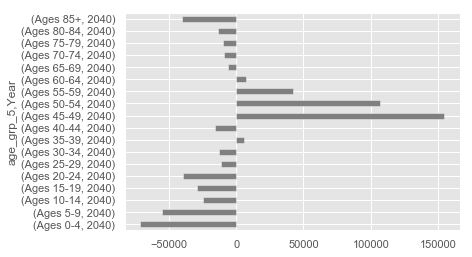

In [24]:
## How does the current age distribution differ from PBA 2040 expectations?

remipop_binned.sum(level=['runid','age_grp_5']).stack().loc[['PBA_2040','R6H2C_plus'],:,2040].unstack(0).diff(axis=1).R6H2C_plus.plot(kind='barh',color='grey')

Text(0.5,1,'Change in age groups, 2015=index 100\nSource: ABAG/MTC, from REMI, "BP Fix it First"')

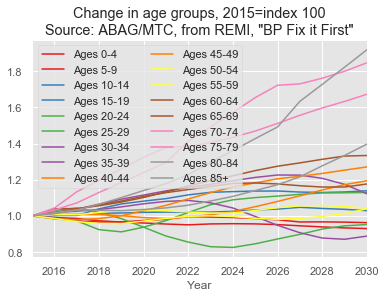

In [25]:
## age group relative growth? The ones growing the most also have high headship rates

((remipop_binned.loc['R6H2C_fix'].sum(level='age_grp_5').T/remipop_binned.loc['R6H2C_fix'].sum(level='age_grp_5').T.loc[2015])).loc[2015:2030].plot(cmap=cm.Set1)
legend(ncol=2)
title('Change in age groups, 2015=index 100\nSource: ABAG/MTC, from REMI, "BP Fix it First"')

### Now, `REMI's` population projection is binned by the same dimensions as the PUMS data used to make headship rates. That means we can easily apply the `PUMS` rates to the appropriate bin counts

But first, REMI's population counts include group quartered populations, so first we need a slight adjustment of the population in these bins, removing counts for group quarters.

From detailed census 2010 data, we get age/gender/race specific rates, which we apply to the future population without adjustments. The result is the REMI household population.


In [30]:
## Load group quarter shares for household population estimates

grp_qtr_shares=pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/census_2010_pums_grp_qtr_%s_%s_binned_shares.csv'%(reg,agegrp)),index_col=None,names=grpqtrbins[1:]+['value'])
pums2010index = grpqtrbins[1:5] if 'Region' in grpqtrbins else grpqtrbins[-3:]

grp_qtr_shares.set_index(pums2010index,inplace=True)
grp_qtr_shares=grp_qtr_shares.value.fillna(0)
grp_qtr_shares.tail(5)

Region    gender  rac_ethn           age_grp_5 
West Bay  Males   White-NonHispanic  Ages 65-69   0.0139
                                     Ages 70-74   0.0215
                                     Ages 75-79   0.0276
                                     Ages 80-84   0.0410
                                     Ages 85+     0.0689
Name: value, dtype: float64

### Load / Prep a bunch of headship rates

We load a number of different versions to test the effect

In [31]:
## PBA rates, post-adjustment

headship_rates = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/headship_rates_adj.csv'),index_col=['rac_ethn','age_grp_5']).PWGTP
headship_rates.head(10)

rac_ethn           age_grp_5 
Black-NonHispanic  Ages 0-4     0.0000
                   Ages 10-14   0.0002
                   Ages 15-19   0.0361
                   Ages 20-24   0.2277
                   Ages 25-29   0.3432
                   Ages 30-34   0.4528
                   Ages 35-39   0.5520
                   Ages 40-44   0.5883
                   Ages 45-49   0.5939
                   Ages 5-9     0.0000
Name: PWGTP, dtype: float64

In [32]:
## load rates that transition from constrained ACS 2018 rates to less constrained 2000 ones over a 15 year period

#headship_rates_phased=pd.read_csv(os.path.join(drop,'Data/PBA2050/headship_acs16_to_c2000.csv'),dtype={'Year':str}).set_index(['Year','rac_ethn','age_grp_5']).value
headship_rates_phased=pd.read_csv(os.path.join(drop,'Data/PBA2050/headship_combo_eased.csv'),dtype={'Year':str}).set_index(['Year','rac_ethn','age_grp_5']).value

#### PBA 2040 convergence adjustments

Percentage point adjustments used in PBA2040

In [33]:
## Prep series for potential adjustment of headship
## Adjustments-these are the NET change, not the targets!

headship_adjust=pd.Series({
 ('White-NonHispanic', 'Ages 25-29'): -0.05,
 ('White-NonHispanic', 'Ages 30-34'): -0.05,
 ('White-NonHispanic', 'Ages 65-69'): -0.05,
 ('White-NonHispanic', 'Ages 70-74'): -0.05,
 ('White-NonHispanic', 'Ages 75-79'): -0.1,
 ('White-NonHispanic', 'Ages 80-84'): -0.1,
 ('White-NonHispanic', 'Ages 85+'): -0.1,
 
 ('Black-NonHispanic', 'Ages 25-29'): -0.05,
 ('Black-NonHispanic', 'Ages 30-34'): -0.05,
 ('Black-NonHispanic', 'Ages 65-69'): -0.05,
 ('Black-NonHispanic', 'Ages 70-74'): -0.05,
 ('Black-NonHispanic', 'Ages 75-79'): -0.1,
 ('Black-NonHispanic', 'Ages 80-84'): -0.1,
 ('Black-NonHispanic', 'Ages 85+'): -0.1})

headship_adjust.index=headship_adjust.index.set_names(['rac_ethn','age_grp_5'])
headship_adjust.head()

rac_ethn           age_grp_5 
Black-NonHispanic  Ages 25-29   -0.0500
                   Ages 30-34   -0.0500
                   Ages 65-69   -0.0500
                   Ages 70-74   -0.0500
                   Ages 75-79   -0.1000
dtype: float64

#### Load a file that is packaged with several rates from a utility script
(`HHPROJ UTIL A - Generate multiregion headship rates from PUMS.ipynb`)

In [34]:
HR_KEEP=[u'Bay Area Census 2000',u'Bay Area ACS 12-16',u'Bay Area ACS 14-18',u'Bay Area ACS 18']
bayarea_hrs=['Bay Area Census 2000','Bay Area ACS 12-16','Bay Area ACS 14-18','Bay Area ACS 18']


In [35]:
## set adjustment flag. Default to false.

ADJUST_RATES=False
#ADJUST_RATES=True


headship_alt=pd.read_csv(os.path.join(drop,'Data/PBA2050/headship_stateregions_vintages.csv'),index_col=['vintage', u'region', u'rac_ethn', u'age_grp_5']).value.fillna(0).reset_index()


headship_alt['geovintage']=headship_alt.region+' '+headship_alt.vintage
headship_alt=headship_alt[headship_alt.geovintage.isin(['Bay Area Census 2000', 'Rest of CA Census 2000',
       #'SANDAG Census 2000', 'SCAG Census 2000',
       'Atlanta Regional ACS 12-16', 'Bay Area ACS 12-16','Bay Area ACS 14-18','Bay Area ACS 18',
       'Rest of CA ACS 12-16', 'SANDAG ACS 12-16', 'SCAG ACS 12-16'])]
headship_alt.age_grp_5=headship_alt.age_grp_5.astype(CategoricalDtype(categories=agebreaker2(breaks_5),ordered=True))
headship_alt=headship_alt.set_index([u'geovintage', u'rac_ethn', u'age_grp_5']).value


## if ADJUST_RATES is true, update rates by adding change

if ADJUST_RATES:

    headship_alt_wide=headship_alt.unstack(0)

    ## BEFORE adjustment values 
    print headship_alt.loc[:,'Black-NonHispanic','Ages 25-29']

    ## use adjustment series to select relevant records only
    # update with the base rates, PLUS the net adjustment from above

    headship_alt_adj=headship_alt_wide.loc[headship_adjust.index].stack().add(headship_adjust).reset_index(name='value').set_index([u'geovintage', u'rac_ethn', u'age_grp_5']).value.sort_index()
    
    ## move back to original headship rate df

    headship_alt.update(headship_alt_adj)

    ## AFTER adjustment values 
    print headship_alt.loc[:,'Black-NonHispanic','Ages 25-29']


### We now have a number of different heaship rates. Create mapping of rates to data, so we can apply multiple rates to the same population projection

In the household projection, we loop through the household population dataframes and then multiply with a number of different headship rates. We store in a dict.

In [36]:
hsr={}
for rgn in headship_alt.index.get_level_values('geovintage').unique():
    if rgn in HR_KEEP:
        hsr['HR %s'%rgn]=headship_alt.loc[rgn]

In [37]:
## Also add PBA 2040 headship rates, as well as the special phased version, from ACS 14-18 to Census 2000 rates

hsr['HR PBA 2040']=headship_rates
hsr['HR Phased']=headship_rates_phased

#### Other prep

We get DOF observed households, to override the early modeled years with observed years

In [38]:
hhs_observed=hh90_19[map(str,range(2011,2020))].sum(level='Region')

#### Prepare source series for early-year transition
As DOF 2019 counts are a bit lower than what is projected in part due to differences in REMI's and DOF's household population, we ease in the early years to avoid a large jump in 2020.

In [39]:
## create base series for easing function with modest growth assumption
## we ease in the difference between this series and the projected one

envelope_year_start=2019
envelope_year_end=2050
base_growth_rate=1.006
t_1=15
t_0=9

source_series={}
for yr in range(envelope_year_start,envelope_year_end+1):
    source_series[str(yr)]=hhs_observed[str(envelope_year_start)]*(base_growth_rate**(yr-envelope_year_start))

source_series=pd.concat(source_series,names=['Year']).unstack('Region')

source_series=hhs_observed.T.append(source_series.loc['2020':])
source_series.index=pd.Index(map(int,source_series.index),dtype=int,name='Year')
source_series.head()

Region,East Bay,North Bay,South Bay,West Bay
Year,,,,
2011,"922,672.0000","377,521.0000","605,402.0000","708,060.0000"
2012,"927,019.0000","378,841.0000","609,109.0000","709,622.0000"
2013,"936,187.0000","380,763.0000","612,406.0000","713,130.0000"
2014,"938,271.0000","381,459.0000","616,841.0000","715,211.0000"
2015,"941,101.0000","382,031.0000","623,590.0000","719,012.0000"


## Do the actual household projection for each scenario in a loop

This is the main event: Using appropriately and identically binned household population data and headship rates to predict households



In [48]:
## last year from DOF observed data to replace in projected households data

DOF_END_OVERRIDE=2019

hhproj_out={}
hhproj_age_out={}
hhproj_eased_out={}
hhpop_out={}
avg_hh_sz_out={}
avg_hh_sz_reg_out={}
for scen_abbrev,scen in scenarios.iteritems():
    print scen,
    output_path=os.path.join(drop,'Data/PBA2050/household_forecast/%s'%scen_abbrev)
    print scen,output_path
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    ## Get Grp quarter, household population from the total remi population using Census 2010 group qtr binned shares
    
    gqpop=remipop_binned.loc[scen_abbrev].stack().mul(grp_qtr_shares,axis=0).unstack('Year')
    
    hhpop=(remipop_binned.loc[scen_abbrev].stack()-gqpop.stack()).unstack('Year').round(0).astype(np.int64)
    hhpop_out[scen_abbrev]=hhpop
    hhpop.columns=hhpop.columns.map(str)
    gqpop.columns=gqpop.columns.map(str)
    
    ## baseyear prep
    ## DEPRECATED since we now use 2015 baseline. 
    ## read 2010 binned data from decennial pums
#     gqpop_binned_2010 = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/census2010pums%s_%s_gqpop_binned.csv'%(reg,agegrp)),index_col=0)
#     hhpop_binned_2010 = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/census2010pums%s_%s_hhpop_binned.csv'%(reg,agegrp)),index_col=0)
#     hhtot_binned_2010 = pd.read_csv(os.path.join(box,'EDF Shared work/control_totals/base_data/census2010pums%s_%s_hhtot_binned.csv'%(reg,agegrp)),index_col=0)

#     #hhpop_binned_2010['runid']=scen
    
#     hhpop_binned_2010.set_index(pums2010index,inplace=True)
#     gqpop_binned_2010.set_index(pums2010index,inplace=True)
#     hhtot_binned_2010.set_index(pums2010index,inplace=True)
    
    ## apply headship rates to REMI-derived hh pop to get projected households
    
    for hrname, hr in hsr.iteritems():
        
        ## make a projection for each headship rate variant
        
        lvls=list(hr.index.names)
        print '\t'+hrname
        
        
        ## Here, we could apply headship rates to the region or subregions as long as it is in the dataframe
                
        if 'Year' in hr.index.names:
            household_projections_tmp=hhpop.stack().sum(level=list(set(['Region','Year']+lvls)))
            household_projections_tmp=household_projections_tmp.reorder_levels(['rac_ethn','age_grp_5','Year','Region'])
            household_projections=hr.reorder_levels(['rac_ethn','age_grp_5','Year']).mul(household_projections_tmp).sum(level=['Region']+lvls)
            
            household_projections=household_projections.unstack('Year')
            lvls.remove('Year')  
        else:
            household_projections = hhpop.fillna(0).sum(level=['Region']+lvls).mul(hr,axis=0)
    
        ## Sum to subregion
        hhproj_age_out[(hrname,scen_abbrev)]=household_projections
        household_projections=household_projections.fillna(0).sum(level=['Region'])
        
        ## update scenario with observed households from DOF, 2011-2019
        
        household_projections.update(hhs_observed[map(str,range(2011,DOF_END_OVERRIDE+1))])
        
        #household_projections_eased=easer(household_projections.T,t_0=10,t_1=20)
        
        ## EASING IN EARLY YEARS - because of jump from observed to projected transition, 
        ## ease in the difference instead of having an artificial one year spike.
        ## 
        target_series=target_series=household_projections.T
        target_series.index=target_series.index.astype(int)
        
        household_projections_eased=easer(
            target_series=target_series,
            source_series=source_series,
            t_0=9,  ## start year 9 after 2011, which is 2020
            t_1=17,
            envelope_year_start=2011,
            envelope_year_end=2050)
        
        
        
        hhpopsum=hhpop.fillna(0).sum(level=['Region']+lvls)
        
        gqpopsum=gqpop.fillna(0).sum(level=['Region']+lvls)
        
        fname = "proj_{geo}_{var}_sc_{scen}_{time:%Y%m%d_%H%M%S}.csv"
        fname2 = "proj_{geo}_{var}_sc_{scen}_eased_{time:%Y%m%d_%H%M%S}.csv"

        #remipop_binned.xs(scen_abbrev).to_csv(os.path.join(output_path,fname.format(geo=reg,var='poptot',scen=scen_abbrev,time=datetime.datetime.now())))  
        ## write output to disk

        #gqpop.to_csv(os.path.join(output_path,fname.format(reg,'gq',scen.replace(' ' ,''),datetime.datetime.now())))  
        household_projections.to_csv(os.path.join(output_path,fname.format(geo=reg,var='hh',scen=scen_abbrev+'_'+hrname.replace(' ','_').replace('-','_'),time=datetime.datetime.now())))  
        household_projections_eased.to_csv(os.path.join(output_path,fname2.format(geo=reg,var='hh',scen=scen_abbrev+'_'+hrname.replace(' ','_').replace('-','_'),time=datetime.datetime.now())))  
        #hhpop.to_csv(os.path.join(output_path,fname.format(reg,'pop',scen.replace(' ' ,''),datetime.datetime.now())))

        ## avg household size is calculated from summed numerators and denomitators 
        
        avg_hh_size = hhpopsum.groupby(level=[0]).sum().div(household_projections.groupby(level=[0]).sum())
        avg_hh_sz_out[(hrname,scen_abbrev)]=avg_hh_size

        ## regional version
        avg_hh_size_reg = avg_hh_size_reg = pd.DataFrame(hhpopsum.sum().div(household_projections.sum())).T
        #avg_hh_size_reg.to_csv(os.path.join(output_path,fname.format(reg,'avg_hh_size_reg',scen.replace(' ' ,''),datetime.datetime.now())))
        #avg_hh_size_reg['runid']=scen
        #avg_hh_size_reg.set_index('runid',inplace=True)
        avg_hh_sz_reg_out[(hrname,scen_abbrev)]=avg_hh_size_reg

        hhproj_out[(hrname,scen_abbrev)]=household_projections
        hhproj_eased_out[(hrname,scen_abbrev)]=household_projections_eased


## concat the dicts from the above loops

hhallscenarios = pd.concat(hhproj_out,axis=0,names=['HR','runid']).fillna(0).astype(np.int64)#.append(hhtot_binned_2010.fillna(0).sum(level=hr.index.names))
hhallscenarios.columns=hhallscenarios.columns.set_names('Year')

hhallscenarios_age = pd.concat(hhproj_age_out,axis=0,names=['HR','runid']).fillna(0).astype(np.int64)#.append(hhtot_binned_2010.fillna(0).sum(level=hr.index.names))
hhallscenarios_age.columns=hhallscenarios_age.columns.set_names('Year')

hheaseallscenarios = pd.concat(hhproj_eased_out,axis=0,names=['HR','runid']).fillna(0).astype(np.int64)#.append(hhtot_binned_2010.fillna(0).sum(level=hr.index.names))
hheaseallscenarios.columns=hheaseallscenarios.columns.set_names('Year')

hhsizescenarios = pd.concat(avg_hh_sz_reg_out,axis=0).fillna(0)
hhsizescenarios.columns=hhsizescenarios.columns.set_names('Year')

hhsizescenarios_subreg = pd.concat(avg_hh_sz_out,axis=0).fillna(0)

hhpopallscenarios = pd.concat(hhpop_out,axis=0,names=['runid']).fillna(0).astype(np.int64)
hhpopallscenarios.columns=hhpopallscenarios.columns.set_names('Year')
#hhpoplevels = index_level_order(hhpopallscenarios) ## order levels
#hhpopallscenarios_sorted=hhpopallscenarios.unstack(hhpoplevels).reset_index().rename(columns={'level_0':'year',0:'value'})


H1_RC2050 H1_RC2050 /Users/aolsen/Dropbox/Data/PBA2050/household_forecast/R5H1C
	HR Bay Area ACS 12-16
	HR Bay Area ACS 14-18
	HR Bay Area ACS 18
	HR Phased
	HR PBA 2040
	HR Bay Area Census 2000
PBA_2040 PBA_2040 /Users/aolsen/Dropbox/Data/PBA2050/household_forecast/PBA_2040
	HR Bay Area ACS 12-16
	HR Bay Area ACS 14-18
	HR Bay Area ACS 18
	HR Phased
	HR PBA 2040
	HR Bay Area Census 2000
Blueprint Plus Crossing Blueprint Plus Crossing /Users/aolsen/Dropbox/Data/PBA2050/household_forecast/R6H2C_plus
	HR Bay Area ACS 12-16
	HR Bay Area ACS 14-18
	HR Bay Area ACS 18
	HR Phased
	HR PBA 2040
	HR Bay Area Census 2000
H2_RC2050 H2_RC2050 /Users/aolsen/Dropbox/Data/PBA2050/household_forecast/R5H2C
	HR Bay Area ACS 12-16
	HR Bay Area ACS 14-18
	HR Bay Area ACS 18
	HR Phased
	HR PBA 2040
	HR Bay Area Census 2000
Blueprint Basic Blueprint Basic /Users/aolsen/Dropbox/Data/PBA2050/household_forecast/R6H2C_basic
	HR Bay Area ACS 12-16
	HR Bay Area ACS 14-18
	HR Bay Area ACS 18
	HR Phased
	HR PBA 204

### Inspect results

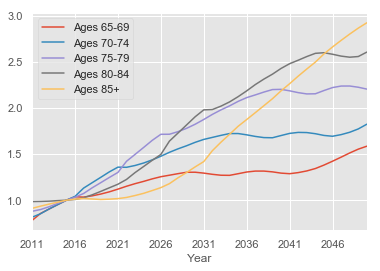

In [49]:
(hhallscenarios_age.sum(level=[0,1,3]).loc(0)['HR Bay Area ACS 18','R6H2C_basic'].T/hhallscenarios_age.sum(level=[0,1,3]).loc(0)['HR Bay Area ACS 18','R6H2C_basic'].T.loc['2015'])[SENIORS].plot()

In [50]:
## check difference remi to DOF
remipop_binned.loc['R6H2C_plus'].sum().loc[2015:2019]-dofpop.loc[2015:2019]

Year
2015   70,527.0000
2016   59,451.0000
2017   44,971.0000
2018   49,350.0000
2019   83,379.0000
dtype: float64

In [51]:
hhs_observed[map(str,range(2011,2020))].sum()

year
2011   2,613,655.0000
2012   2,624,591.0000
2013   2,642,486.0000
2014   2,651,782.0000
2015   2,665,734.0000
2016   2,688,044.0000
2017   2,697,256.0000
2018   2,709,051.0000
2019   2,723,550.0000
dtype: float64

In [52]:
hhallscenarios.stack().loc[[u'HR Bay Area ACS 12-16', 
                            u'HR Bay Area ACS 14-18', 
                            u'HR Bay Area ACS 18',
                           'HR Phased',
                           'HR Bay Area Census 2000'],'R6H2C_fix',:,
                           ['2019']+map(str,range(2015,2036,5))].sum(
    level=['HR','runid','Year']).unstack('Year').T#.plot(kind='bar')
#legend(loc=3)

HR,HR Bay Area ACS 12-16,HR Bay Area ACS 14-18,HR Bay Area ACS 18,HR Bay Area Census 2000,HR Phased
runid,R6H2C_fix,R6H2C_fix,R6H2C_fix,R6H2C_fix,R6H2C_fix
Year,,,,,
2015,2665734,2665734,2665734,2665734,2665734
2019,2723550,2723550,2723550,2723550,2723550
2020,2881995,2841692,2809468,3021188,2841692
2025,3069612,3028667,2996357,3214389,3030996
2030,3225018,3183501,3151491,3376573,3258555
2035,3383953,3341198,3307236,3542290,3520354


Text(0.5,1.05,'Effect of different headship rates on yearly household counts\nHRs begin at 2018 (latest) levels, then phase in Census 2000 levels by 2030')

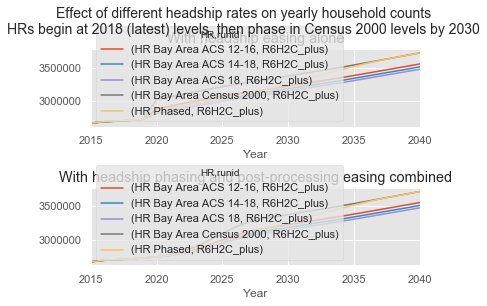

In [53]:
fig,ax=plt.subplots(nrows=2)
hhallscenarios.stack().loc[[u'HR Bay Area ACS 12-16', 
                            u'HR Bay Area ACS 14-18', 
                            u'HR Bay Area ACS 18',
                           'HR Phased',
                           'HR Bay Area Census 2000'],'R6H2C_plus',:,
                           map(str,range(2015,2041))].sum(
    level=['HR','runid','Year']).unstack('Year').T.plot(ax=ax[0])
hheaseallscenarios.stack().loc[[u'HR Bay Area ACS 12-16', 
                            u'HR Bay Area ACS 14-18', 
                            u'HR Bay Area ACS 18',
                           'HR Phased',
                           'HR Bay Area Census 2000'],'R6H2C_plus',:,
                           map(str,range(2015,2041))].sum(
    level=['HR','runid','Year']).unstack('Year').T.plot(ax=ax[1])
ax[0].set_title('With headship easing alone')
ax[1].set_title('With headship phasing and post-processing easing combined')
plt.tight_layout()
plt.suptitle('Effect of different headship rates on yearly household counts\nHRs begin at 2018 (latest) levels, then phase in Census 2000 levels by 2030',size=14,y=1.05)     

Text(0.5,1.05,'Effect of different headship rates on yearly household counts\nHRs begin at 2018 (latest) levels, then phase in Census 2000 levels by 2030')

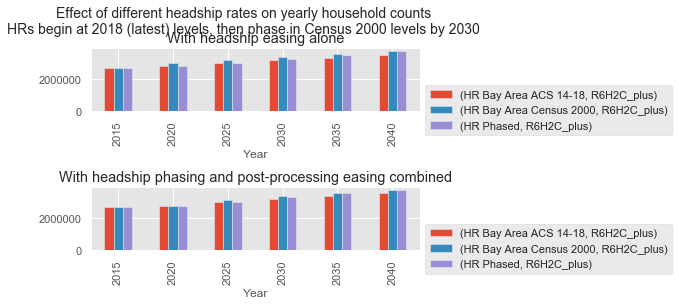

In [54]:
fig,ax=plt.subplots(nrows=2)
hhallscenarios.stack().loc[[#u'HR Bay Area ACS 12-16', 
                            u'HR Bay Area ACS 14-18', 
#                            u'HR Bay Area ACS 18',
                           'HR Phased',
                           'HR Bay Area Census 2000'
],'R6H2C_plus',:,
                           map(str,range(2015,2041,5))].sum(
    level=['HR','runid','Year']).unstack('Year').T.plot(kind='bar',ax=ax[0])
hheaseallscenarios.stack().loc[[#u'HR Bay Area ACS 12-16', 
                            u'HR Bay Area ACS 14-18', 
#                            u'HR Bay Area ACS 18',
                           'HR Phased',
                           'HR Bay Area Census 2000'
],'R6H2C_plus',:,
                           map(str,range(2015,2041,5))].sum(
    level=['HR','runid','Year']).unstack('Year').T.plot(kind='bar',ax=ax[1])
ax[0].set_title('With headship easing alone')
ax[1].set_title('With headship phasing and post-processing easing combined')
plt.tight_layout()
ax[1].legend(bbox_to_anchor=(1,.5))
ax[0].legend(bbox_to_anchor=(1,.5))
plt.suptitle('Effect of different headship rates on yearly household counts\nHRs begin at 2018 (latest) levels, then phase in Census 2000 levels by 2030',size=14,y=1.05)     

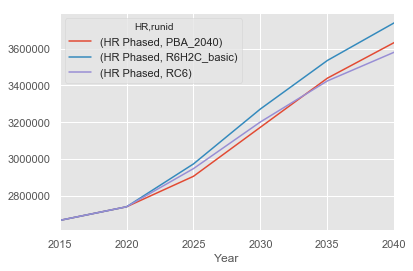

In [55]:
HR_topsheet='HR Bay Area ACS 12-16'
HR_topsheet='HR Phased'

hheaseallscenarios.sum(level=['HR','runid']).loc(0)[HR_topsheet,['RC6','R6H2C_basic','PBA_2040']].T.loc[YEARS_5_str[1:-2]].plot()

Text(0.5,1,'Major spike in annual change in households, when using DOF observed HHs through 2019')

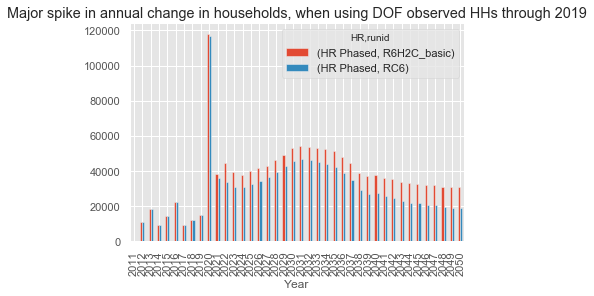

In [56]:
## unfortuntate transition situation observed -> modeled
hhallscenarios.sum(level=['HR','runid']).loc(0)[HR_topsheet,['RC6','R6H2C_basic']].T.diff().plot(kind='bar')
title('Major spike in annual change in households, when using DOF observed HHs through 2019')

Text(0.5,1,'Blueprint Fix-it-First, Annualized change in households, with:\n a) Headship transition 2022-2038; \nb) obs-to-model year easing 2020-2027')

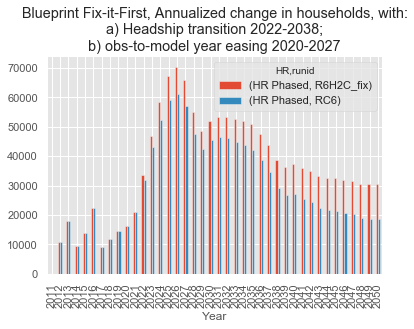

In [57]:
## transition with phased headship rates and easing

hheaseallscenarios.sum(level=['HR','runid']).loc(0)[HR_topsheet,['RC6','R6H2C_fix']].T.diff().plot(kind='bar')
title('Blueprint Fix-it-First, Annualized change in households, with:\n a) Headship transition 2022-2038; \nb) obs-to-model year easing 2020-2027')

In [58]:
#hheaseallscenarios.sum(level=['HR','runid']).loc(0)[HR_topsheet,['RC6','R6H2C_fix']].T.loc[YEARS_5_str]

(2500000.0, 4270886.55)

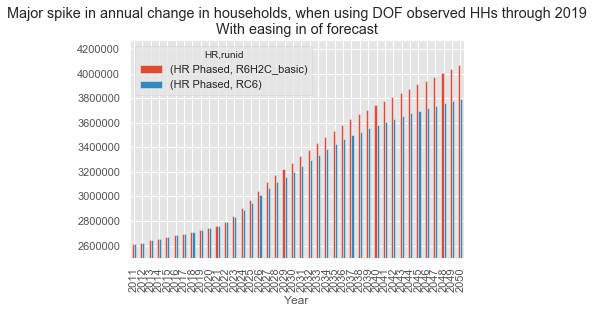

In [59]:
hheaseallscenarios.sum(level=['HR','runid']).loc(0)[HR_topsheet,['RC6','R6H2C_basic']].T.plot(kind='bar')
title('Major spike in annual change in households, when using DOF observed HHs through 2019\nWith easing in of forecast')
ylim(ymin=2.5e6)

### Topsheet prep

In [60]:
#### For complete time series with observed counts, add DOF observed 
## to each projected series for completeness

## DOF Expand to each scenario - PPH

dofpphexp={}
for k, v in hhallscenarios.stack().sum(level=['runid']).iteritems():
    #print k
    dofpphexp[('Obs',k)]=dofhhsize_hist.reset_index(level=[1,0],drop=True)
pphdof_hist=pd.concat(dofpphexp,names=['HR','runid','Year'])

dofexp={}
for k, v in hhallscenarios.stack().sum(level=['runid']).iteritems():
    print k
    dofexp[('Obs',k)]=dofhh_hist.reset_index(level=[1,2],drop=True)
hhdof_hist=pd.concat(dofexp,names=['HR','runid','Year'])

PBA_2040
R5H0C
R5H1C
R5H2C
R6H2C_basic
R6H2C_fix
R6H2C_plus
RC5
RC6


In [61]:
#avg_hh_pop_variants=(hhpopallscenarios.sum(level=['runid'])/hhallscenarios.sum(level=['HR','runid'])).stack().sort_index().append(pphdof_hist).append(pba_pph).reset_index(name='value')
#avg_hh_pop_variants#.to_csv(os.path.join(drop,'Data/PBA2050/pers_per_hh_variants.csv'))

In [62]:
hhallscenarios_r=hhallscenarios.stack().sum(level=['HR','runid','Year']).sort_index().append(hhdof_hist).reset_index(name='value')
hhallscenarios_r.Year=hhallscenarios_r.Year.astype(int)
hhallscenarios_r=hhallscenarios_r.set_index(['Year','HR','runid']).value
hhallscenarios_r.loc[range(2000,2051,5)].reset_index(name='value').to_csv(os.path.join(drop,'Data/PBA2050/hhproj_x_scen_x_HR.csv'))

In [63]:
#remipop.Year=remipop.Year.astype(str)
pd.DataFrame(data={'2015':[7423305]},index=scenarios.keys())

,2015
R5H1C,7423305
PBA_2040,7423305
R6H2C_plus,7423305
R5H2C,7423305
R6H2C_basic,7423305
R6H2C_fix,7423305
RC5,7423305
RC6,7423305
R5H0C,7423305


In [111]:
topsheet_hhpop=hhpopallscenarios.stack().sum(level=['runid','Year']).loc[:,YEARS_15_50_str].unstack('Year')
#topsheet_hhpop.update(pd.DataFrame(data={'2015':[7423305]},index=scenarios.keys()))
#topsheet_hhpop=topsheet_hhpop.append(pbahhpop)


### Fetch a smaller subset of data from the full set of scenario x headship rates

In [65]:
pd.options.display.float_format = '{:,.1f}'.format

In [66]:
## More curated version with specific combinations of headship rates 
## and runids defined in `scenario_to_headship_map`

curated={}
for i,v in enumerate(scenario_to_headship_map.iteritems()):
    #print i,v
    if v[0]!='PBA_2040':
        curated[v]=hheaseallscenarios.stack().sum(level=['runid','HR','Region','Year']).loc[v]
hh_curated=pd.concat(curated,names=['runid','HR'])

topsheet_hh_curated=hh_curated.sum(level=['HR','runid','Region','Year']).loc[:,:,:,map(str,range(2015,2051,1))].unstack('Year')
#topsheet_hh_curated.update(pd.DataFrame(data={'2015':[2678810],'2011':[2678810]},index=topsheet_hh_curated.index))

## add pba 2040 from TAZDATA
topsheet_hh_curated=topsheet_hh_curated.append(pbadatasubreg)

## add historical data

topsheet_hh_curated=hh90_19.append(topsheet_hh_curated).sort_index(level=1)#.append(pbafuthh.set_index(['HR','runid']).households)

In [67]:
pd.options.display.float_format = '{:,.2f}'.format

vac_easing=easer(target_series=pd.Series(.05,index=pd.Index(map(int,YEARS_1_str),name='Year')).to_frame(name='value'),
     source_series=pd.Series(.03,index=pd.Index(map(int,YEARS_1_str),name='Year')).to_frame(name='value'),
      t_0=7,t_1=15,envelope_year_start=2015,envelope_year_end=2050
).T.value#.reset_index(1).value
vac_easing.index=vac_easing.index.astype(str)


(topsheet_hh_curated.sum(level=[0,1]).div(1-vac_easing)/1e6)[YEARS_15_50_str]

2015  2020  2025  2030  2035  2040  2045  2050
HR                    runid                                                      
                      Observed     2.75  0.00  0.00  0.00  0.00  0.00  0.00  0.00
HR PBA 2040           PBA_2040     2.85  2.97  3.12  3.31  3.45  3.61  0.00  0.00
HR Bay Area ACS 14-18 R5H0C        2.75  2.82  3.06  3.30  3.43  3.57  3.71  3.85
HR PBA 2040           R5H1C        2.75  2.82  3.09  3.35  3.48  3.63  3.78  3.93
HR Phased             R5H2C        2.75  2.82  3.09  3.43  3.69  3.89  4.06  4.23
                      R6H2C_basic  2.75  2.82  3.08  3.44  3.72  3.94  4.12  4.28
                      R6H2C_fix    2.75  2.82  3.08  3.43  3.71  3.92  4.10  4.26
                      R6H2C_plus   2.75  2.82  3.08  3.43  3.71  3.92  4.10  4.26
HR PBA 2040           RC5          2.75  2.82  3.08  3.32  3.45  3.58  3.71  3.84
HR Bay Area ACS 14-18 RC6          2.75  2.82  3.06  3.29  3.42  3.56  3.68  3.78

In [125]:
pd.options.display.float_format = '{:,.1f}'.format

In [126]:
## avg hh size
topsheet_hhpop.loc[BLUEPRINT_RUNS].mean()/topsheet_hh_curated.loc(0)[:,BLUEPRINT_RUNS][YEARS_5_str].stack().sum(level=[0,1,3]).mean(level=2)

Year
2015   2.8
2020   2.8
2025   2.8
2030   2.6
2035   2.5
2040   2.5
2045   2.5
2050   2.5
dtype: float64

In [101]:
vacancy_rates=pd.concat([pd.Series(.017,index=map(str,range(2015,2020))),
           pd.Series(np.linspace(start=.017,stop=.05,num=11),index=map(str,range(2020,2031))),
           pd.Series(.05,index=map(str,range(2031,2051)))])


In [128]:
## HOUSEHOLDS, in millions
(topsheet_hh_curated.loc(0)[:,BLUEPRINT_RUNS][YEARS_5_str].stack().sum(level=[0,1,3]).mean(level=2)/1e6)

2015   2.7
2020   2.7
2025   3.0
2030   3.3
2035   3.5
2040   3.7
2045   3.9
2050   4.0
dtype: float64

In [134]:
topsheet_hh_curated.loc(0)[:,BLUEPRINT_RUNS][YEARS_5_str].stack().sum(level=[0,1,3]).unstack([0,1])

HR      HR Phased            
runid   R6H2C_fix  R6H2C_plus
2015  2,665,734.0 2,665,734.0
2020  2,739,890.0 2,739,890.0
2025  2,966,820.0 2,966,951.0
2030  3,258,555.0 3,258,583.0
2035  3,520,354.0 3,520,177.0
2040  3,724,198.0 3,723,903.0
2045  3,893,272.0 3,892,901.0
2050  4,048,622.0 4,048,228.0

In [131]:
## UNITS, assuming the stated vacancy rates. 2013-2017 units, limited universe (not other vacant):  2,748,025 
((topsheet_hh_curated.loc(0)[:,BLUEPRINT_RUNS][YEARS_5_str].stack().sum(level=[0,1,3]).mean(level=2))/(1-vacancy_rates)).dropna().diff().sum()

1549664.8016276704

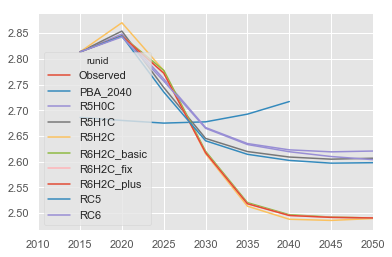

In [70]:
## note the drop in average household size - largely driven by a relatively older population

(topsheet_hhpop/topsheet_hh_curated.sum(level='runid'))[YEARS_5_str].T.plot()

In [71]:
# ## for r
# topsheet_hh_curated_r=topsheet_hh_curated.stack().reset_index(name='value').rename(columns={'level_2':'year'})

# topsheet_hh_curated_r.to_csv(os.path.join(drop,'Data/PBA2050/hhproj_combo_hist.csv'))

#### Write data for excel topsheet

In [72]:

xlpth=os.path.join(box,'Modeling and Surveys/Regional Modeling/Housing/PBA50 Housing/PBA50 Household Forecast/basic household forecast/hhtopsheet_{:%Y_%m_%d__%H_%M}.xlsx'.format(datetime.datetime.now()))

xlout=pd.ExcelWriter(xlpth)

topsheet_hh_curated.sort_index(level=1).sum(level=['HR','runid']).loc(1)[YEARS_5_str].replace(0,nan).to_excel(xlout,'Household Projection Orig')
topsheet_hhpop.to_excel(xlout,'Household Population Projection')
(topsheet_hhpop/topsheet_hh_curated.sum(level='runid')[topsheet_hhpop.columns]).sort_index(level=1).to_excel(xlout,'Household Size Projection')
xlout.close()

wb = openpyxl.load_workbook(xlpth,read_only=False) 
sht=wb.create_sheet('README',index=0)
c1 = sht.cell(row = 1, column = 1) 
c2 = sht.cell(row = 3, column = 1) 
c3 = sht.cell(row = 5, column = 1) 
c4 = sht.cell(row = 7, column = 1) 
  
# writing values to cells 
c1.value = "Headship Rates Used:"
#c2.value = HR_topsheet
#c3.value = "Headship Rates Adjusted:"
#c4.value = 'Yes' if ADJUST_RATES else 'No'

for i,v in enumerate(scenario_to_headship_map.iteritems()):

    cx = sht.cell(row = 3+i, column = 1) 
    cy = sht.cell(row = 3+i, column = 2)
    cx.value=v[0]
    cy.value=v[1]

wb.save(xlpth)
wb.close()